<a href="https://colab.research.google.com/github/MuthiahAinun/topic-modeling-mental-health-convo/blob/main/LDA_BERTopic_mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [6]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 8.5 MB/s eta 0:00:00


In [7]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from langdetect import detect
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [8]:
# Membaca dan Menampilkan informasi dataset
df = pd.read_csv("data.csv")
print("Jumlah data:", len(df))

Jumlah data: 5667


In [9]:
print(df.head())

                                             Context  \
0  Aku sedang melalui beberapa hal dengan perasaa...   
1  Aku sedang melalui beberapa hal dengan perasaa...   
2  Aku sedang melalui beberapa hal dengan perasaa...   
3  Aku sedang melalui beberapa hal dengan perasaa...   
4  Aku sedang melalui beberapa hal dengan perasaa...   

                                            Response  
0  Jika semua orang berpikir Anda tidak berharga,...  
1  Halo,  dan terima kasih atas pertanyaan Anda d...  
2  Hal pertama yang saya sarankan adalah mendapat...  
3  Terapi sangat penting bagi mereka yang merasa ...  
4  Pertama-tama saya ingin memberi tahu Anda bahw...  


In [10]:
print("Informasi Dataset:")
print(df.info())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5667 entries, 0 to 5666
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   5667 non-null   object
 1   Response  5667 non-null   object
dtypes: object(2)
memory usage: 88.7+ KB
None


In [11]:
# Statistik deskriptif
print("\nStatistik deskriptif:")
print(df.describe(include="all"))


Statistik deskriptif:
                                                  Context  \
count                                                5667   
unique                                               1127   
top     Bagaimana Anda tahu Anda memiliki terapis yang...   
freq                                                  146   

                                                 Response  
count                                                5667  
unique                                               3504  
top     Seringkali orang dengan trauma berat mengalami...  
freq                                                    4  


In [12]:
# Mengecek jumlah missing values di setiap kolom
print(df.isnull().sum())

Context     0
Response    0
dtype: int64


In [13]:
# Cek apakah ada baris duplikat
print("\nJumlah duplikat:", df.duplicated().sum())


Jumlah duplikat: 2139


In [14]:
print(f"Total data: {len(df)}")
print(f"Jumlah duplikat: {df.duplicated().sum()}")
print(f"Persentase duplikat: {df.duplicated().sum()/len(df)*100:.2f}%")

Total data: 5667
Jumlah duplikat: 2139
Persentase duplikat: 37.74%


In [15]:
# Simpan dataset asli untuk pembanding
df_original = df.copy()

# Hapus duplikat
df_dedup = df.drop_duplicates().reset_index(drop=True)

print("Data awal:", len(df_original))
print("Data setelah hapus duplikat:", len(df_dedup))

Data awal: 5667
Data setelah hapus duplikat: 3528


In [16]:
# Versi dengan data asli (ada duplikat)
for col in df.select_dtypes(include=["object"]).columns:
    print(f"\nDistribusi nilai kolom {col} (data asli):")
    print(df[col].value_counts().head(10))

# Versi dengan data tanpa duplikat
for col in df_dedup.select_dtypes(include=["object"]).columns:
    print(f"\nDistribusi nilai kolom {col} (setelah hapus duplikat):")
    print(df_dedup[col].value_counts().head(10))


Distribusi nilai kolom Context (data asli):
Context
Bagaimana Anda tahu Anda memiliki terapis yang tepat untuk Anda?  Bagaimana saya tahu bagaimana "melatih" terapis saya untuk dapat memberi saya apa yang saya butuhkan dari perawatan?                                                                                                                                                                                                                                                                                                        146
Saya memiliki banyak masalah untuk diatasi.  Saya memiliki riwayat pelecehan seksual,  saya seorang penderita kanker payudara dan saya adalah insomnia seumur hidup.  Saya memiliki sejarah panjang depresi dan saya mulai memiliki kecemasan.  Saya memiliki harga diri yang rendah tetapi saya telah menikah dengan bahagia selama hampir 35 tahun.  Saya tidak pernah memiliki konseling tentang semua ini.  Apakah saya memiliki terlalu banyak masalah untuk diatasi dalam k

In [17]:
# Buat kolom panjang teks pada data yang sudah dibersihkan
df_dedup["context_length"] = df_dedup["Context"].apply(lambda x: len(str(x).split()))
df_dedup["response_length"] = df_dedup["Response"].apply(lambda x: len(str(x).split()))

# Cek ringkasan statistik
print(df_dedup[["context_length", "response_length"]].describe())

       context_length  response_length
count     3528.000000      3528.000000
mean        44.142574       153.053855
std         38.045953       106.978721
min          2.000000         1.000000
25%         20.000000        80.000000
50%         38.000000       126.000000
75%         58.000000       194.000000
max        460.000000       905.000000


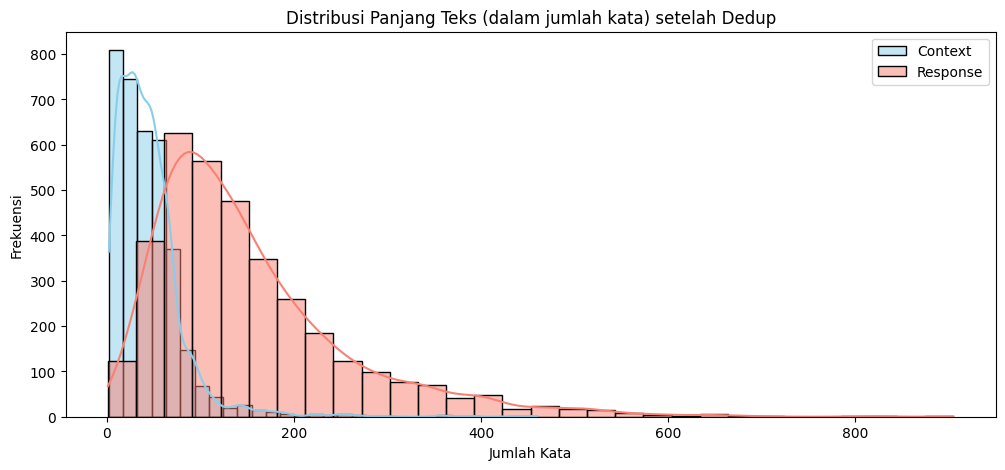

In [18]:
# Histogram panjang teks (pakai data sudah dedup)
plt.figure(figsize=(12,5))
sns.histplot(df_dedup["context_length"], bins=30, color="skyblue", label="Context", kde=True)
sns.histplot(df_dedup["response_length"], bins=30, color="salmon", label="Response", kde=True)
plt.legend()
plt.title("Distribusi Panjang Teks (dalam jumlah kata) setelah Dedup")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

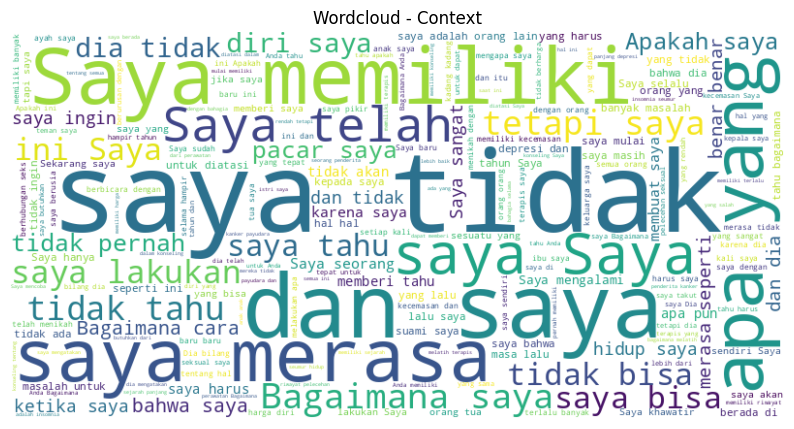

In [19]:
# Wordcloud untuk Context
context_text = " ".join(df_dedup["Context"].astype(str).tolist())
wordcloud_context = WordCloud(width=800, height=400, background_color="white").generate(context_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_context, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Context")
plt.show()

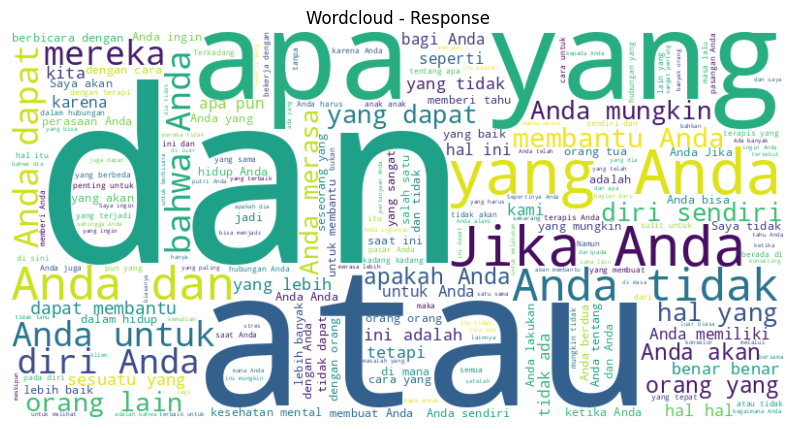

In [20]:
# Wordcloud untuk Response
response_text = " ".join(df_dedup["Response"].astype(str).tolist())
wordcloud_response = WordCloud(width=800, height=400, background_color="white").generate(response_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_response, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Response")
plt.show()

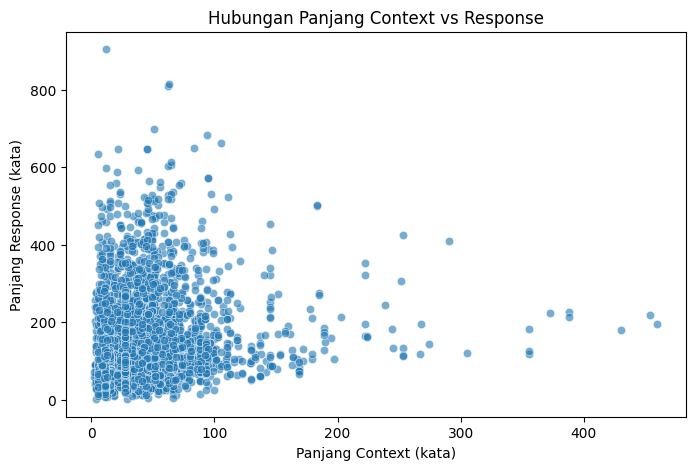

In [21]:
# Scatter plot panjang Context vs Response
plt.figure(figsize=(8,5))
sns.scatterplot(x="context_length", y="response_length", data=df_dedup, alpha=0.6)
plt.title("Hubungan Panjang Context vs Response")
plt.xlabel("Panjang Context (kata)")
plt.ylabel("Panjang Response (kata)")
plt.show()

# Data Cleaning & Preprocessing

In [22]:
# 1. Gabungkan semua teks (Context + Response)
text_data = " ".join(df_dedup["Context"].astype(str)) + " " + " ".join(df_dedup["Response"].astype(str))

# =====================
# 2. Cleaning teks
# =====================
# Lowercase
text_data = text_data.lower()

# Hilangkan angka & tanda baca
text_data = re.sub(r"[^a-zA-Z\s]", " ", text_data)

# =====================
# 3. Hapus stopwords
# =====================
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Tambahin manual kata ganti yang sering muncul
custom_stopwords = {"saya", "anda", "aku", "kamu", "kita", "dia", "jika", "dan", "atau", "apa", "untuk", "adalah", "yang", "jadi"}
stopwords = stopwords.union(custom_stopwords)

# Filter kata
filtered_words = [word for word in text_data.split() if word not in stopwords]

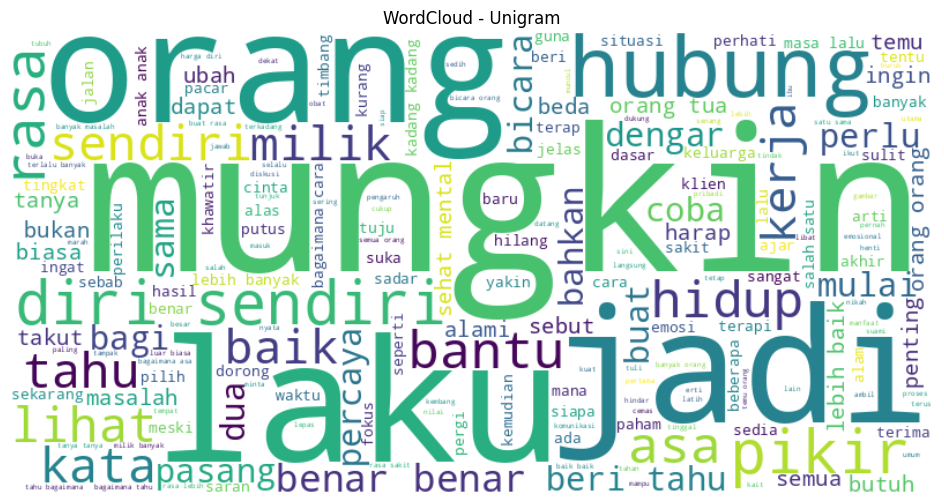

In [23]:
# =====================
# 4. Stemming
# =====================

stemmer = StemmerFactory().create_stemmer()

# Stemming untuk hasil gabungan (untuk wordcloud global)
stemmed_words = [stemmer.stem(word) for word in filtered_words]
cleaned_text = " ".join(stemmed_words)

# Stemming per dokumen (Context + Response)
def stem_sentence(words):
    return " ".join([stemmer.stem(w) for w in words])

df_dedup["stemmed_text"] = df_dedup["Context"].astype(str) + " " + df_dedup["Response"].astype(str)
df_dedup["stemmed_text"] = (
    df_dedup["stemmed_text"]
    .str.lower()
    .apply(lambda x: re.sub(r"[^a-zA-Z\s]", " ", x))  # bersihkan angka/tanda baca
    .apply(lambda x: " ".join([w for w in x.split() if w not in stopwords]))  # hapus stopwords
    .apply(lambda x: stem_sentence(x.split()))  # stemming
)

# Simpan juga cleaned_text biar konsisten
df_dedup["cleaned_text"] = df_dedup["stemmed_text"]

# =====================
# 5. WordCloud & Visualisasi Unigram
# =====================
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis"
).generate(cleaned_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("WordCloud - Unigram")
plt.axis("off")
plt.show()

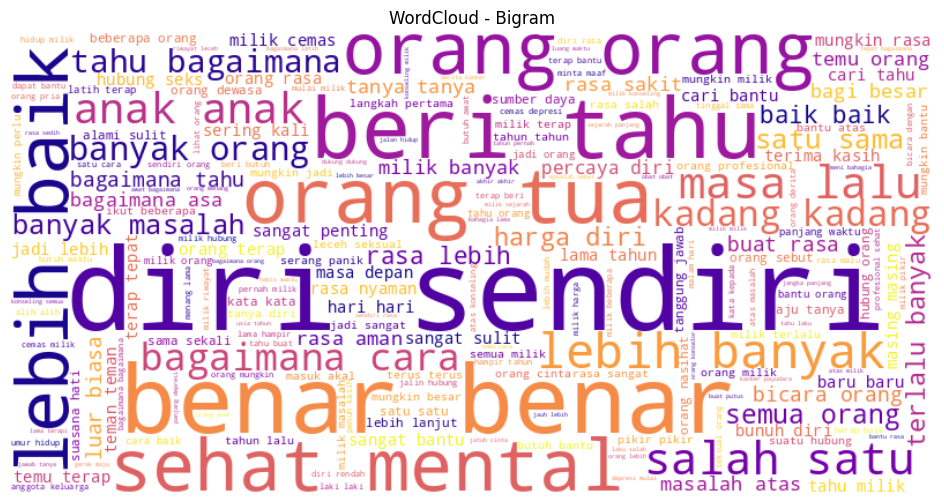

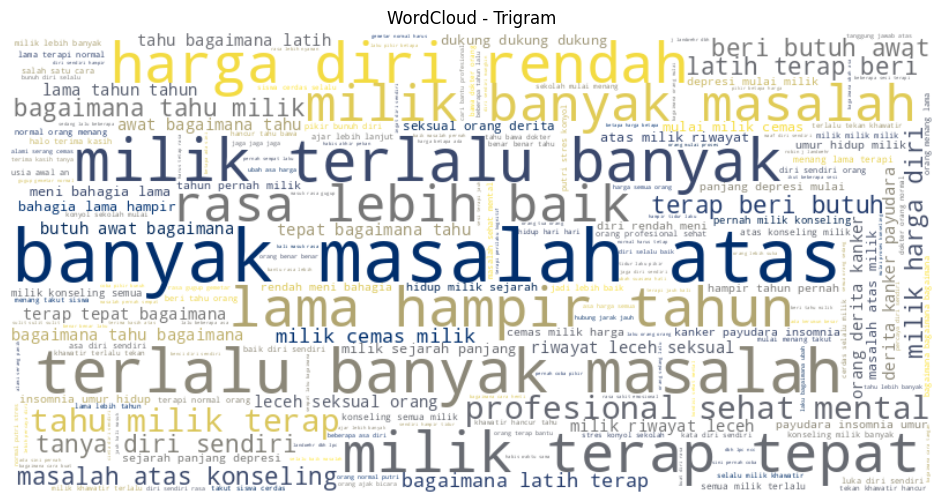

In [24]:
# =========================================
# 6. Bigram & Trigram
# =========================================

# ==== Visualisasi Bigram ====
bigrams = list(ngrams(stemmed_words, 2))
bigram_freq = Counter(bigrams)

bigram_dict = {" ".join(k): v for k, v in bigram_freq.items()}
wordcloud_bigram = WordCloud(width=800, height=400, background_color="white", colormap="plasma").generate_from_frequencies(bigram_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_bigram, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Bigram")
plt.show()

# ==== Visualisasi Trigram ====
trigrams = list(ngrams(stemmed_words, 3))
trigram_freq = Counter(trigrams)

trigram_dict = {" ".join(k): v for k, v in trigram_freq.items()}
wordcloud_trigram = WordCloud(width=800, height=400, background_color="white", colormap="cividis").generate_from_frequencies(trigram_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_trigram, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Trigram")
plt.show()

In [25]:
# Ambil 15 bigram teratas
top_15_bigrams = bigram_freq.most_common(15)

print("Top 15 Bigrams:")
for bg, freq in top_15_bigrams:
    print(f"{' '.join(bg)} : {freq}")

Top 15 Bigrams:
diri sendiri : 1714
benar benar : 1103
beri tahu : 845
orang tua : 705
orang orang : 626
sehat mental : 620
lebih baik : 611
lebih banyak : 575
masa lalu : 500
salah satu : 493
anak anak : 447
bagaimana cara : 442
kadang kadang : 436
banyak orang : 376
tahu bagaimana : 346


In [26]:
# Ambil 15 Trigram teratas
top_15_trigrams = trigram_freq.most_common(15)

print("Top 15 Trigrams:")
for bg, freq in top_15_trigrams:
    print(f"{' '.join(bg)} : {freq}")

Top 15 Trigrams:
banyak masalah atas : 217
terlalu banyak masalah : 151
milik terlalu banyak : 137
harga diri rendah : 125
milik terap tepat : 123
lama hampir tahun : 120
milik banyak masalah : 119
rasa lebih baik : 118
profesional sehat mental : 117
tahu milik terap : 115
masalah atas konseling : 114
tanya diri sendiri : 112
bagaimana tahu milik : 111
terap beri butuh : 111
beri butuh awat : 111


# Modeling

## LDA

In [27]:
# ==== Deteksi Bahasa Indonesia ====
df_dedup["is_indonesian"] = df_dedup["cleaned_text"].apply(lambda x: True if detect(x) == "id" else False)

# Ambil hanya dokumen berbahasa Indonesia
documents = df_dedup[df_dedup["is_indonesian"]]["cleaned_text"].astype(str).tolist()

# ==== Vectorizer ====
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
doc_term_matrix = vectorizer.fit_transform(documents)

# ==== LDA ====
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(doc_term_matrix)

# ==== Tampilkan topik ====
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    top_terms = [(terms[i], topic[i]) for i in topic.argsort()[:-11:-1]]
    print(f"Topik {idx+1}: ", top_terms)

Topik 1:  [('orang', np.float64(2713.1010311061614)), ('mungkin', np.float64(1708.6486299704)), ('tahu', np.float64(1676.0942902311901)), ('benar', np.float64(1377.9570996945283)), ('rasa', np.float64(1211.1993769415483)), ('tanya', np.float64(1181.0643540115893)), ('laku', np.float64(1172.4045596087112)), ('kata', np.float64(1170.396585768458)), ('lebih', np.float64(1167.077342521471)), ('buat', np.float64(983.3993318898099))]
Topik 2:  [('orang', np.float64(2079.5436994127654)), ('bantu', np.float64(1864.3147483359112)), ('terap', np.float64(1597.511851111738)), ('milik', np.float64(1379.663387602311)), ('cemas', np.float64(1330.485265223288)), ('rasa', np.float64(1244.3904959504248)), ('mungkin', np.float64(1201.3104526868356)), ('terapi', np.float64(963.1640576481408)), ('sehat', np.float64(935.9929978847244)), ('beberapa', np.float64(874.0871424309204))]
Topik 3:  [('anak', np.float64(1651.630743719353)), ('orang', np.float64(1002.5432452718308)), ('ibu', np.float64(747.1163311117

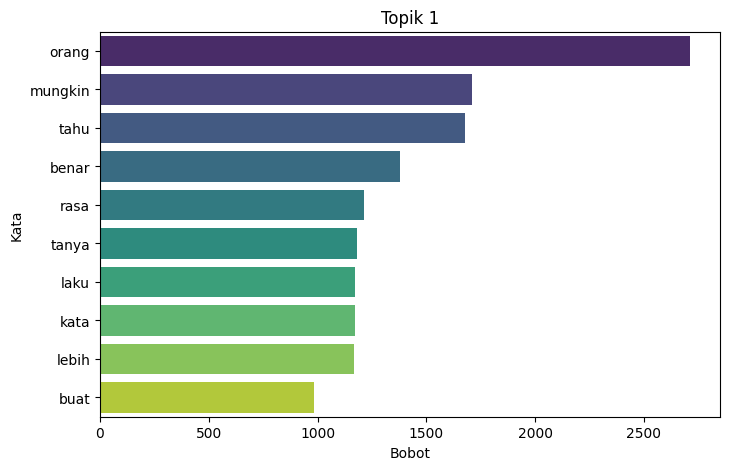

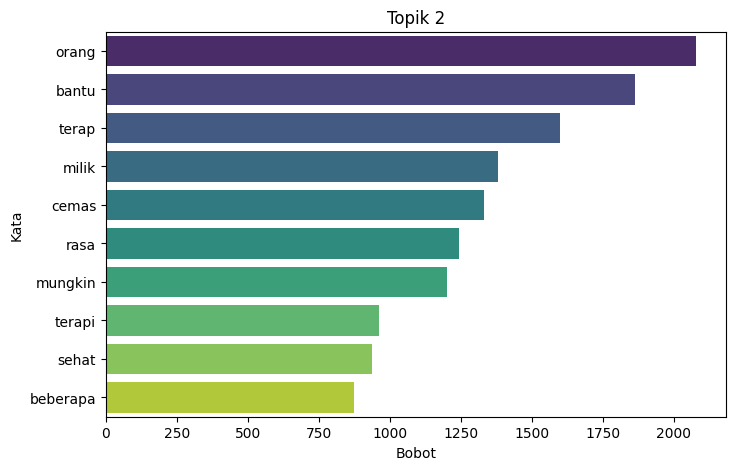

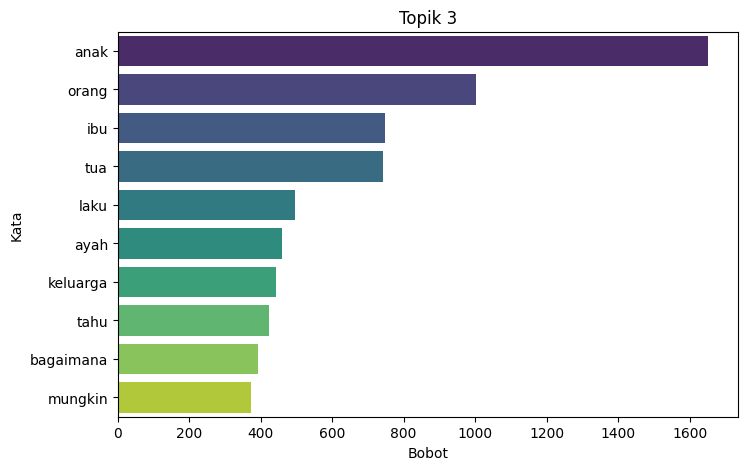

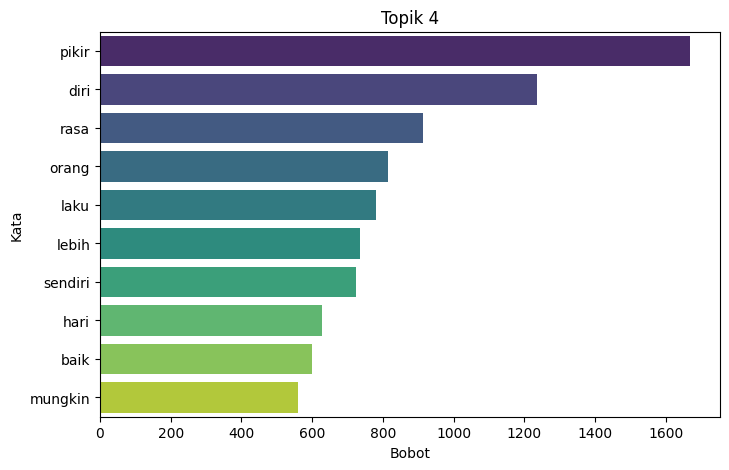

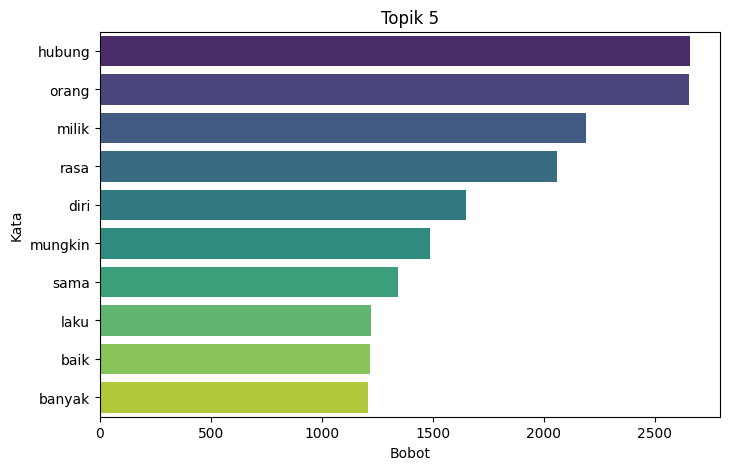

In [28]:
# jumlah top kata per topik
n_top_words = 10
terms = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda_model.components_):
    plt.figure(figsize=(8, 5))
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [terms[i] for i in top_indices]
    top_weights = topic[top_indices]

    sns.barplot(x=top_weights, y=top_terms, palette="viridis")
    plt.title(f"Topik {idx+1}")
    plt.xlabel("Bobot")
    plt.ylabel("Kata")
    plt.show()

## BERTopic

In [30]:
# Gabungkan dokumen (misalnya context + response)
docs = df_dedup["cleaned_text"].astype(str).tolist()

# Model
topic_model = BERTopic(language="indonesian")
topics, probs = topic_model.fit_transform(docs)

# Info topik
topic_model.get_topic_info()

# Visualisasi
topic_model.visualize_topics()
topic_model.visualize_barchart(top_n_topics=10)